# Data Exploration

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
import os

# Add the project root to the Python path to import the modules
project_root = Path().absolute().parent
sys.path.append(str(project_root))

## A/ Sentinel-1 data

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.plot import show
import geopandas as gpd
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches
import contextily as ctx
from shapely.geometry import mapping

# Set paths
vv_path = "../data/preprocessed/sentinel/20240503/20240503_sigma0_vv_db.tif"
vh_path = "../data/preprocessed/sentinel/20240503/20240503_sigma0_vh_db.tif"
aoi_path = "../utils/AOI_bboxes/aoi_shifa.geojson"

# Read the GeoJSON AOI
aoi = gpd.read_file(aoi_path)

In [16]:
# Function to read and visualize SAR data
def visualize_sar_data(vv_path, vh_path, aoi, figsize=(18, 12)):
    # Open the raster files
    with rasterio.open(vv_path) as vv_src, rasterio.open(vh_path) as vh_src:
        # Read the data
        vv_data = vv_src.read(1)
        vh_data = vh_src.read(1)
        
        # Calculate VV/VH ratio (in dB this is subtraction)
        ratio_data = vv_data - vh_data
        
        # Define color ranges for better visualization
        # SAR backscatter in dB typically ranges from -25 to 0 for land areas
        vmin_vv, vmax_vv = -25, 0
        vmin_vh, vmax_vh = -30, -5
        vmin_ratio, vmax_ratio = 0, 15
        
        # Create the plot with 3 subplots
        fig, axs = plt.subplots(1, 3, figsize=figsize)
        
        # Plot VV polarization
        img1 = axs[0].imshow(vv_data, cmap='gray', vmin=vmin_vv, vmax=vmax_vv)
        axs[0].set_title('VV Polarization (dB)', fontsize=15)
        plt.colorbar(img1, ax=axs[0], shrink=0.7)
        
        # Plot VH polarization
        img2 = axs[1].imshow(vh_data, cmap='gray', vmin=vmin_vh, vmax=vmax_vh)
        axs[1].set_title('VH Polarization (dB)', fontsize=15)
        plt.colorbar(img2, ax=axs[1], shrink=0.7)
        
        # Plot VV/VH ratio
        img3 = axs[2].imshow(ratio_data, cmap='viridis', vmin=vmin_ratio, vmax=vmax_ratio)
        axs[2].set_title('VV/VH Ratio (dB)', fontsize=15)
        plt.colorbar(img3, ax=axs[2], shrink=0.7)
        
        # Adjust layout
        plt.tight_layout()
        plt.suptitle('Sentinel-1 Preprocessed SAR Data - Gaza (Shifa Area)', fontsize=18, y=1.05)
        
        return fig, axs, (vv_src, vh_src, vv_data, vh_data, ratio_data)

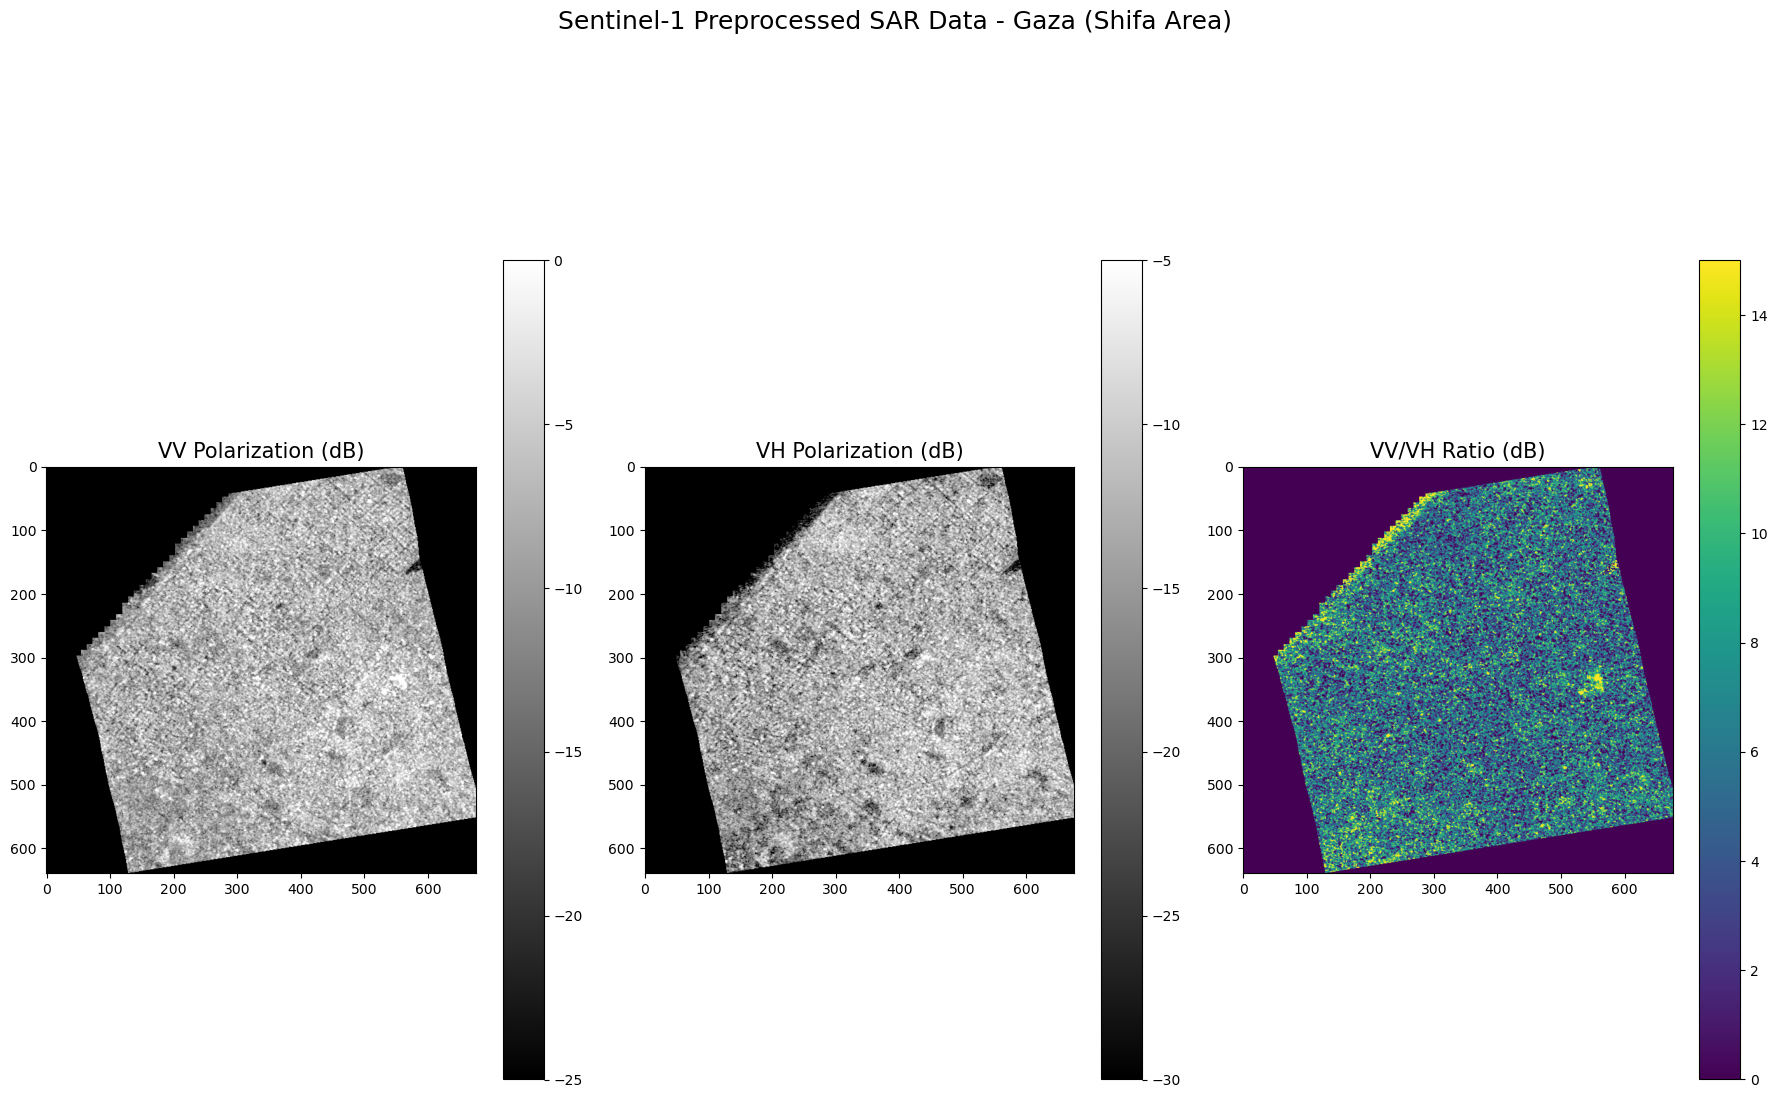

In [17]:
# Basic visualization of SAR data
fig1, axs1, data_info = visualize_sar_data(vv_path, vh_path, aoi)

In [19]:
# Function to create a more advanced map with basemap and AOI overlay
def create_detailed_map(vv_path, vh_path, aoi, figsize=(18, 12)):
    # Open the raster files
    with rasterio.open(vv_path) as vv_src, rasterio.open(vh_path) as vh_src:
        # Read the data
        vv_data = vv_src.read(1)
        vh_data = vh_src.read(1)
        
        # Create figure with 2 rows, 2 columns
        fig, axs = plt.subplots(2, 2, figsize=figsize)
        axs = axs.flatten()
        
        # Plot VV polarization with AOI boundary
        show(vv_data, ax=axs[0], cmap='gray', vmin=-25, vmax=0, transform=vv_src.transform)
        aoi.boundary.plot(ax=axs[0], color='red', linewidth=2)
        axs[0].set_title('VV Polarization with AOI Boundary', fontsize=14)
        
        # Plot VH polarization with AOI boundary
        show(vh_data, ax=axs[1], cmap='gray', vmin=-30, vmax=-5, transform=vh_src.transform)
        aoi.boundary.plot(ax=axs[1], color='red', linewidth=2)
        axs[1].set_title('VH Polarization with AOI Boundary', fontsize=14)
        
        # Calculate RGB composite (False color)
        # Normalize the data for RGB visualization
        vv_norm = np.clip((vv_data - (-25)) / (0 - (-25)), 0, 1)
        vh_norm = np.clip((vh_data - (-30)) / (-5 - (-30)), 0, 1)
        ratio_norm = np.clip((vv_data - vh_data) / 15, 0, 1)
        
        # Create RGB composite (R: VV, G: VH, B: VV/VH ratio)
        rgb = np.dstack((vv_norm, vh_norm, ratio_norm))
        
        # Plot RGB composite
        axs[2].imshow(rgb)
        aoi.boundary.plot(ax=axs[2], color='yellow', linewidth=2)
        axs[2].set_title('RGB Composite (R:VV, G:VH, B:Ratio)', fontsize=14)
        
        # Project the AOI to Web Mercator for basemap
        aoi_web_mercator = aoi.to_crs(epsg=3857)
        
        # Plot AOI on basemap
        aoi_web_mercator.plot(ax=axs[3], alpha=0.5, color='blue')
        aoi_web_mercator.boundary.plot(ax=axs[3], color='red', linewidth=2)
        
        # Add basemap
        try:
            ctx.add_basemap(axs[3], source=ctx.providers.OpenStreetMap.Mapnik)
        except Exception as e:
            print(f"Could not add basemap: {e}")
            # Alternative: just show the AOI
            axs[3].set_title('AOI Boundary (Basemap Failed to Load)', fontsize=14)
        else:
            axs[3].set_title('AOI on Basemap', fontsize=14)
        
        # Set extent to the AOI
        bounds = aoi_web_mercator.bounds.iloc[0]
        axs[3].set_xlim(bounds.minx, bounds.maxx)
        axs[3].set_ylim(bounds.miny, bounds.maxy)
        
        # Add legend
        red_patch = mpatches.Patch(color='red', label='AOI Boundary')
        blue_patch = mpatches.Patch(color='blue', label='AOI Area')
        axs[3].legend(handles=[red_patch, blue_patch], loc='upper right')
        
        # Adjust layout
        plt.tight_layout()
        plt.suptitle('Sentinel-1 Data Analysis - Gaza (Shifa Area)', fontsize=18, y=1.05)
        
        return fig, axs

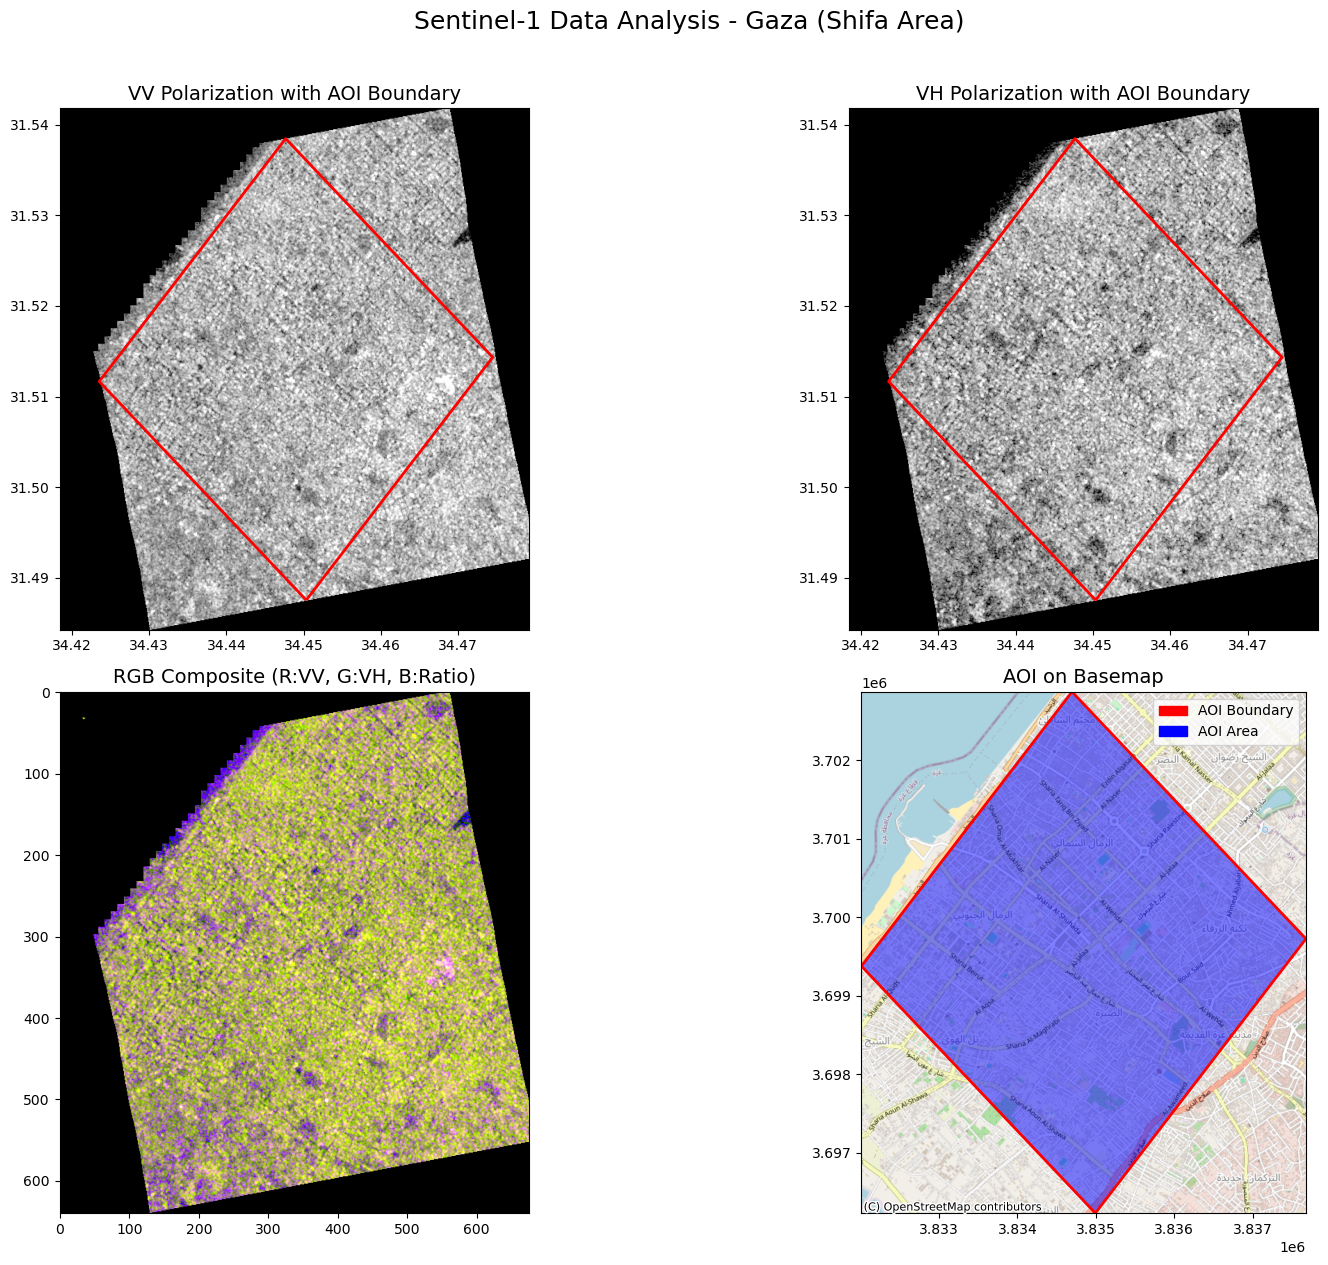

In [20]:
# Advanced visualization with basemap and AOI
fig2, axs2 = create_detailed_map(vv_path, vh_path, aoi)

In [21]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping, Point
import matplotlib.pyplot as plt

# Read the AOI
aoi = gpd.read_file(aoi_path)

# Function to extract backscatter values within the AOI
def extract_backscatter_within_aoi(raster_path, aoi, band=1):
    """
    Extract backscatter values for pixels within an AOI.
    
    Parameters:
    -----------
    raster_path : str
        Path to the raster file (GeoTIFF)
    aoi : GeoDataFrame
        GeoDataFrame containing the AOI polygon
    band : int, default=1
        Band number to read
        
    Returns:
    --------
    masked_data : numpy.ma.MaskedArray
        Masked array with backscatter values (only within AOI)
    pixel_coords : list of tuples
        List of (x, y) coordinates in the original raster's CRS
    geo_coords : list of tuples
        List of (lon, lat) coordinates
    """
    with rasterio.open(raster_path) as src:
        # Create a mask for the AOI
        masked_data, masked_transform = mask(src, aoi.geometry, crop=True, all_touched=True, nodata=np.nan)
        masked_data = masked_data[0]  # Take the first band
        
        # Get the valid pixels (not masked)
        valid_pixels = ~np.isnan(masked_data)
        y_indices, x_indices = np.where(valid_pixels)
        
        # Convert pixel indices to coordinates
        pixel_coords = []
        geo_coords = []
        for y, x in zip(y_indices, x_indices):
            # Get pixel center coordinates in the raster's CRS
            px, py = rasterio.transform.xy(masked_transform, y, x, offset='center')
            pixel_coords.append((x, y))
            geo_coords.append((px, py))
            
        return masked_data, pixel_coords, geo_coords

In [22]:
# Extract values from VV and VH polarizations
vv_data, vv_pixel_coords, vv_geo_coords = extract_backscatter_within_aoi(vv_path, aoi)
vh_data, vh_pixel_coords, vh_geo_coords = extract_backscatter_within_aoi(vh_path, aoi)

# Create a DataFrame with the backscatter values and coordinates
backscatter_data = []

# Gather data points
for (x, y), (lon, lat), vv_val, vh_val in zip(
    vv_pixel_coords, vv_geo_coords, 
    vv_data[~np.isnan(vv_data)], 
    vh_data[~np.isnan(vh_data)]
):
    # Calculate VV/VH ratio
    ratio = vv_val - vh_val  # In dB, subtraction is equivalent to ratio
    
    backscatter_data.append({
        'x': x,
        'y': y,
        'longitude': lon,
        'latitude': lat,
        'vv_db': vv_val,
        'vh_db': vh_val,
        'vv_vh_ratio_db': ratio,
        'geometry': Point(lon, lat)
    })

# Convert to GeoDataFrame
backscatter_gdf = gpd.GeoDataFrame(backscatter_data, geometry='geometry')

# Set the CRS to match the raster
with rasterio.open(vv_path) as src:
    backscatter_gdf.crs = src.crs

# Display first few rows
print(f"Total pixels within AOI: {len(backscatter_gdf)}")
display(backscatter_gdf.head())

Total pixels within AOI: 162052


,x,y,longitude,latitude,vv_db,vh_db,vv_vh_ratio_db,geometry
0,267,0,34.447578,31.538414,-70.000000,-70.000000,0.000000,POINT (34.44758 31.53841)
1,268,0,34.447668,31.538414,-12.339082,-12.535957,0.196876,POINT (34.44767 31.53841)
2,269,0,34.447757,31.538414,-6.615949,-15.154619,8.538670,POINT (34.44776 31.53841)
3,266,1,34.447488,31.538324,-10.693115,-12.657718,1.964602,POINT (34.44749 31.53832)
4,267,1,34.447578,31.538324,-8.690508,-10.235926,1.545418,POINT (34.44758 31.53832)


In [10]:
# Function to get backscatter values at specific coordinates
def get_backscatter_at_coords(lon, lat, backscatter_gdf, tolerance=0.0001):
    """Get backscatter values at or near specific coordinates"""
    # Find the closest point within tolerance
    close_points = backscatter_gdf[
        (backscatter_gdf['longitude'] > lon - tolerance) &
        (backscatter_gdf['longitude'] < lon + tolerance) &
        (backscatter_gdf['latitude'] > lat - tolerance) &
        (backscatter_gdf['latitude'] < lat + tolerance)
    ]
    
    if len(close_points) > 0:
        # Return the closest point
        return close_points.iloc[0]
    else:
        return None

In [12]:
example_lon, example_lat = 34.45, 31.51  # Example coordinates within your AOI
point_data = get_backscatter_at_coords(example_lon, example_lat, backscatter_gdf)

## B/ UNOSAT labels

In [27]:
import folium
from folium.plugins import MarkerCluster, HeatMap
import datetime
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from utils.preprocessing_UNOSAT_helpers import list_gdb_layers, load_all_unosat_damage_sites, inspect_layer_properties

In [29]:
# UNOSAT GDB path
gdb_path = "../data/raw/labels/UNOSAT_GazaStrip_CDA_25February2025.gdb"
layers = list_gdb_layers(gdb_path)

print(f"\nLayers in the GDB ({len(layers)} layers):")
for i, layer in enumerate(layers):
    print(f"{i+1}. {layer}")

# Load all layers
damage_data = load_all_unosat_damage_sites()


Layers in the GDB (5 layers):
1. Damage_Sites_GazaStrip_20250225
2. fras_aux_IDP_Sites_Template_FC
3. fras_blk_IDP_Sites_Template_FC
4. fras_bnd_IDP_Sites_Template_FC
5. fras_ras_IDP_Sites_Template_FC
UNOSAT data directory not found: /Users/matteolarrode/Documents/Oxford/Applied ML/Summative/data/raw/labels/unosat


In [ ]:
# Inspect the damage layer
gdf = inspect_layer_properties(gdb_path, layers[0])

Inspecting layer: Damage_Sites_GazaStrip_20250225 in /Users/matteolarrode/Documents/Oxford/Applied ML/Summative/ML-BuildingDamageViaSatellite/data/raw/labels/25_02_2025/UNOSAT_GazaStrip_CDA_25February2025.gdb

Basic Information:
Number of features: 173350
Geometry type: Point
CRS: COMPD_CS["WGS 84 + EGM96 height",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]],VERT_CS["EGM96 height",VERT_DATUM["EGM96 geoid",2005,AUTHORITY["EPSG","5171"]],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Gravity-related height",UP],AUTHORITY["EPSG","5773"]]]

Columns (64 total):
 - SiteID: int16, 173350/173350 non-null values
   Sample values: [26, 26, 26]
 - SensorDate: datetime64[ms, UTC], 14270/173350 non-null values
   Sample values: [Timestamp('2023-1

## C/ Building footprints

In [ ]:
# ---- Focus on Gaza data ----
import seaborn as sns
from utils.preprocessing_footprints_helpers import load_building_data
from utils.mapping_helpers import parse_geo_column, create_folium_map

region_name = "Gaza"
gaza_data = load_building_data(region_name)

Loaded footprint data from: Gaza_20240503_1_footprints.csv
Loaded grid data from: Gaza_20240503_2_grid.csv


/Users/matteolarrode/Documents/Oxford/Applied ML/Summative/ML-BuildingDamageViaSatellite/src/data/preprocess.py:40: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  result['footprints'] = pd.read_csv(footprint_path)



--- Gaza Footprints Data Summary ---
Shape: (228730, 13)

Columns:
 - system:index
 - area
 - building
 - class
 - damage_pts
 - k100
 - k150
 - k50
 - max_change
 - name
 - osm_id
 - osm_type
 - .geo

Data types:
system:index     object
area            float64
building         object
class             int64
damage_pts        int64
k100            float64
k150            float64
k50             float64
max_change      float64
name             object
osm_id            int64
osm_type         object
.geo             object
dtype: object

First 5 rows:
           system:index         area building  class  damage_pts      k100  \
0  00000000000000032e7e   237.967586   church      1           1  3.196825   
1  00000000000000032e33  2960.776123   mosque      1           4  4.270218   
2  00000000000000032e6f   937.639565   mosque      1           1  4.604129   
3  00000000000000032e38   772.664673   public      1           7  3.856997   
4  00000000000000032e90  1950.263063   public      1  

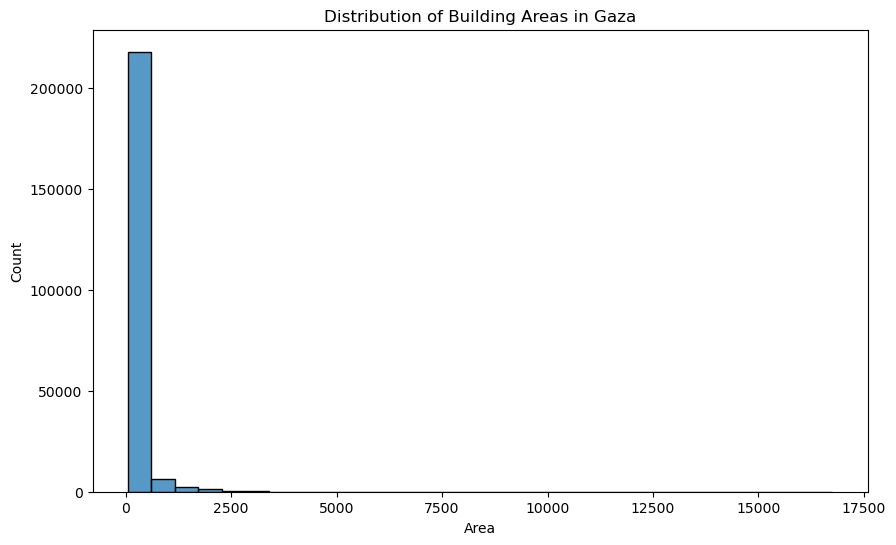

In [27]:
# ---- Footprints data ----
# Load the data
gaza_footprints = gaza_data['footprints']

if gaza_footprints is not None:
    print("\n--- Gaza Footprints Data Summary ---")
    print(f"Shape: {gaza_footprints.shape}")
    print("\nColumns:")
    for col in gaza_footprints.columns:
        print(f" - {col}")
    
    print("\nData types:")
    print(gaza_footprints.dtypes)
    
    print("\nFirst 5 rows:")
    print(gaza_footprints.head())
    
    print(f"\nPercent of buildings damaged: {sum(gaza_footprints['class'] / len(gaza_footprints)) * 100:.2f}%")

    # Visualize building areas
    plt.figure(figsize=(10, 6))
    sns.histplot(gaza_footprints['area'], bins=30)
    plt.title('Distribution of Building Areas in Gaza')
    plt.xlabel('Area')
    plt.ylabel('Count')
    plt.show()

In [28]:
# ---- Grid data ----
gaza_grid = gaza_data['grid']

if gaza_grid is not None:
    print("\n--- Gaza Grid Data Summary ---")
    print(f"Shape: {gaza_grid.shape}")
    print("\nColumns:")
    for col in gaza_grid.columns:
        print(f" - {col}")
    
    print("\nData types:")
    print(gaza_grid.dtypes)
    
    print("\nFirst 5 rows:")
    print(gaza_grid.head())
    
    # Basic statistics
    print("\nSummary statistics:")
    print(gaza_grid.describe())
    
    print(f"\nPercent of grid points damaged: {sum(gaza_grid['class'] / len(gaza_grid)) * 100:.2f}%")



--- Gaza Grid Data Summary ---
Shape: (1784, 9)

Columns:
 - system:index
 - class
 - damage_pts
 - k100
 - k150
 - k50
 - max_change
 - urban
 - .geo

Data types:
system:index     object
class             int64
damage_pts        int64
k100            float64
k150            float64
k50             float64
max_change      float64
urban           float64
.geo             object
dtype: object

First 5 rows:
  system:index  class  damage_pts      k100      k150       k50  max_change  \
0    7628,7326      1           3  2.873321  2.756077  2.965370    3.009428   
1    7628,7327      1           7  2.832489  2.824138  2.847125    2.843848   
2    7627,7328      1           7  2.708110  2.640692  2.769818    2.809486   
3    7628,7328      1          22  3.882189  3.855844  3.884454    3.886829   
4    7629,7328      1           4  3.042172  2.957090  3.131401    3.167469   

      urban                                               .geo  
0  0.184330  {"geodesic":false,"crs":{"type":"name

### Map of damaged buildings in Gaza

In [ ]:
print("Converting Gaza footprints to GeoDataFrame...")
gaza_footprints_gdf = parse_geo_column(gaza_footprints)
    
print("Creating map showing damaged vs. undamaged buildings (using 'class' column)...")
damage_class_map = create_folium_map(
    gaza_footprints_gdf,
    title="Gaza Building Damage",
    use_class_for_damage=True
)

display(damage_class_map)